<a href="https://colab.research.google.com/github/Dolewma/retail_demand_forecast/blob/main/course_project_week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import necessary libraries
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/df_prepared_guayas.csv')

In [4]:
df.head(10)

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-04-08,4018215,24,96995,1.0,False,2013,4,8,0,1.000000
1,2013-04-09,0,24,96995,0.0,0,2013,4,9,1,0.500000
2,2013-04-10,0,24,96995,0.0,0,2013,4,10,2,0.333333
3,2013-04-11,0,24,96995,0.0,0,2013,4,11,3,0.250000
4,2013-04-12,0,24,96995,0.0,0,2013,4,12,4,0.200000
5,2013-04-13,0,24,96995,0.0,0,2013,4,13,5,0.166667
6,2013-04-14,0,24,96995,0.0,0,2013,4,14,6,0.142857
7,2013-04-15,0,24,96995,0.0,0,2013,4,15,0,0.000000
8,2013-04-16,0,24,96995,0.0,0,2013,4,16,1,0.000000
9,2013-04-17,0,24,96995,0.0,0,2013,4,17,2,0.000000


In [5]:
df = df[(df['date'] >= '2014-01-01') & (df['date'] < '2014-04-01')]

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
stores = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/stores.csv')
items = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/items.csv')
transactions = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data//transactions.csv')
oil = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/oil.csv')
holidays = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/holidays_events.csv')

In [43]:
# Datumsbasierte Features
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week.astype(int)
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Lag-Feature: Durchschnittsverkäufe der letzten 7 Tage
# Zuerst sortieren (wichtig!)
df = df.sort_values(['store_nbr', 'item_nbr', 'date'])

# Lag-basierte Features
df['unit_sales_1d_lag'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df['unit_sales_7d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(7).mean().reset_index(0, drop=True)
df['unit_sales_14d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(14).mean().reset_index(0, drop=True)
df['unit_sales_30d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(30).mean().reset_index(0, drop=True)


# Verkaufsstatus als bool
df['onpromotion'] = df['onpromotion'].astype(int)


In [9]:
oil['date'] = pd.to_datetime(oil['date'])
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()
oil = oil.sort_values('date')

# Mehrere gleitende Durchschnitte
oil['oil_price_1d_lag'] = oil['dcoilwtico'].shift(1)
oil['oil_price_7d_avg'] = oil['dcoilwtico'].shift(1).rolling(7).mean()
oil['oil_price_14d_avg'] = oil['dcoilwtico'].shift(1).rolling(14).mean()
oil['oil_price_30d_avg'] = oil['dcoilwtico'].shift(1).rolling(30).mean()

# Merge
df = df.merge(
    oil[['date', 'dcoilwtico', 'oil_price_1d_lag', 'oil_price_7d_avg', 'oil_price_14d_avg', 'oil_price_30d_avg']],
    on='date',
    how='left'
)


In [10]:
# Datum konvertieren
holidays['date'] = pd.to_datetime(holidays['date'])

# Filter: Nur nationale, nicht verschobene Feiertage
filtered_holidays = holidays[(holidays['locale'] == 'National') & (holidays['transferred'] == False)].copy()

# Wenn nach dem Filter nichts übrig bleibt, Warnung
if filtered_holidays.empty:
    print("⚠️ Keine Feiertage nach dem Filter gefunden – 'is_holiday' wird 0.")
    df['is_holiday'] = 0
else:
    # Feiertagsspalte markieren
    filtered_holidays['is_holiday'] = 1

    # Merge mit df
    df = df.merge(filtered_holidays[['date', 'is_holiday']], on='date', how='left')

    # Fehlende Feiertage = 0
    df['is_holiday'] = df['is_holiday'].fillna(0)


In [44]:
features = [
    'store_nbr',

    # Zeitmerkmale
    'day', 'week', 'month', 'day_of_week', 'is_weekend',

    # Promotion
    'onpromotion',

    # Ölpreis und Trends
    'dcoilwtico',
    'oil_price_1d_lag',
    'oil_price_7d_avg',
    'oil_price_14d_avg',
    'oil_price_30d_avg',

    # Feiertage
    'is_holiday',

    # Optional: Lag-basierte Verkäufe
    'unit_sales_1d_lag',
    'unit_sales_7d_avg',
    'unit_sales_14d_avg',
    'unit_sales_30d_avg'
]


In [12]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [45]:
# 1. Filter nur auf Jan–März 2014 (falls noch nicht gemacht)
df = df[(df['date'] >= '2014-01-01') & (df['date'] <= '2014-03-31')]

# 2. Sortieren nach Datum (wichtig!)
df = df.sort_values('date')

# 3. Finde 80%-Cutoff innerhalb Jan–März 2014
cutoff_index = int(len(df) * 0.8)
cutoff_date = df.iloc[cutoff_index]['date']

# 4. Split nach diesem Datum
train = df[df['date'] <= cutoff_date]
test = df[df['date'] > cutoff_date]

# 5. Drop NaNs (vor Ziel/Features-Zuweisung!)
train = train.dropna(subset=features + ['unit_sales'])
test = test.dropna(subset=features + ['unit_sales'])

# 6. Zielvariable und Features zuweisen
y_train = np.log1p(train['unit_sales'])
y_test = test['unit_sales']

X_train = train[features]
X_test = test[features]



In [46]:
# Modell initialisieren
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Modell trainieren
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

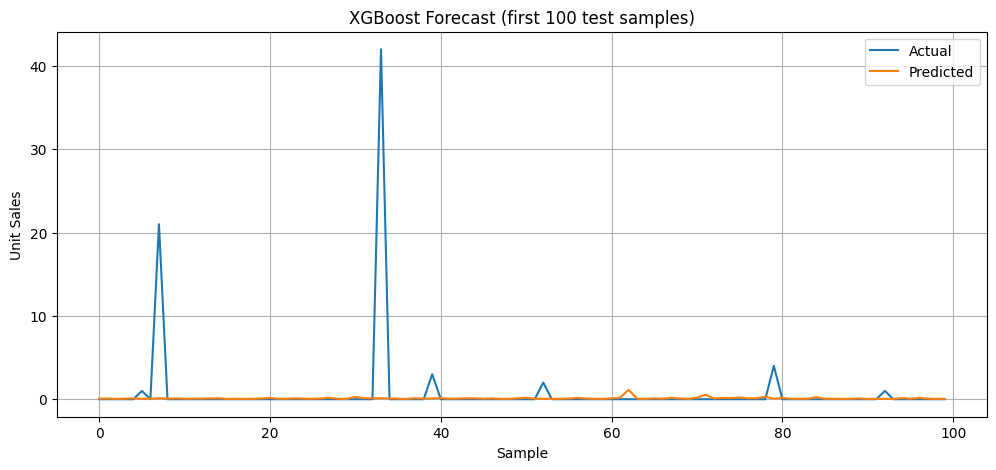

In [47]:
# Vorhersage erzeugen
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Nur die ersten 100 Beispiele plotten

plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('XGBoost Forecast (first 100 test samples)')
plt.xlabel('Sample')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()


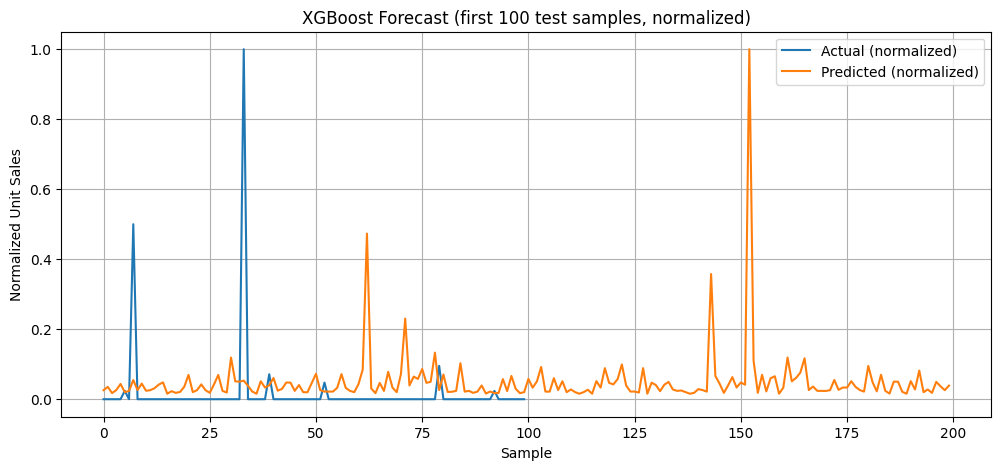

In [51]:
plt.figure(figsize=(12, 5))

# Normalisierung auf [0, 1]
y_actual_norm = y_test.values[:100] / y_test.values[:100].max()
y_pred_norm = y_pred[:200] / y_pred[:200].max()

plt.plot(y_actual_norm, label='Actual (normalized)')
plt.plot(y_pred_norm, label='Predicted (normalized)')
plt.title('XGBoost Forecast (first 100 test samples, normalized)')
plt.xlabel('Sample')
plt.ylabel('Normalized Unit Sales')
plt.legend()
plt.grid(True)
plt.show()

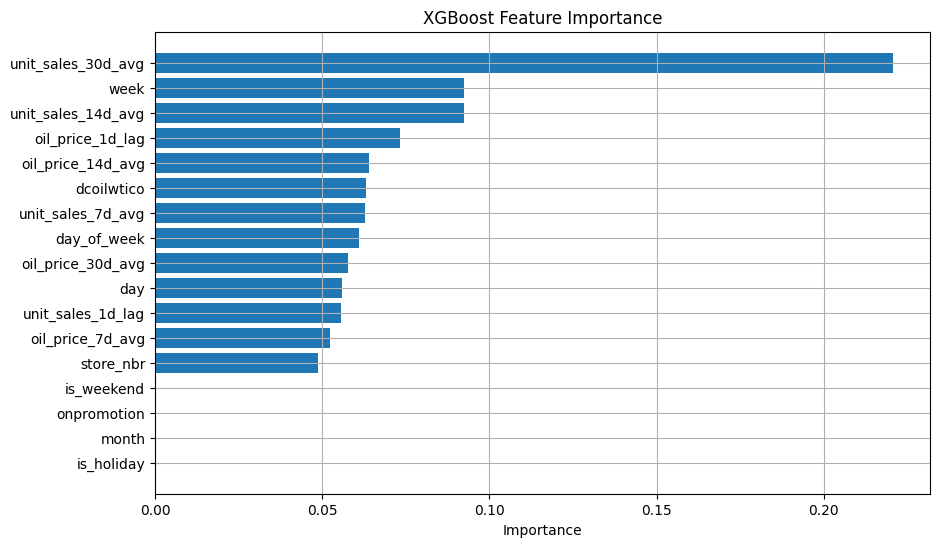

In [49]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.grid(True)
plt.show()


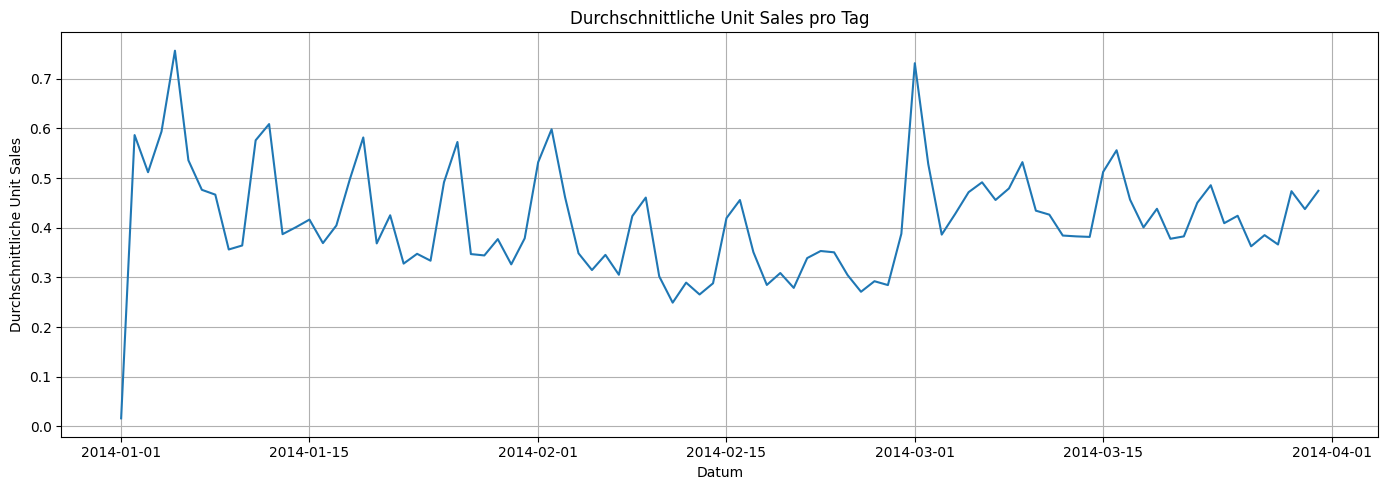

In [18]:

# Mittelwert pro Tag über alle Stores & Items (für Übersicht)
daily_sales = df.groupby('date')['unit_sales'].mean()

plt.figure(figsize=(14, 5))
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Durchschnittliche Unit Sales pro Tag')
plt.xlabel('Datum')
plt.ylabel('Durchschnittliche Unit Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# TensorFlow for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Skalieren
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features + ['unit_sales']].dropna())

In [21]:
# Sequenzen erstellen
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])
        y.append(data[i + window_size, -1])
    return np.array(X), np.array(y)

window_size = 14
X_lstm, y_lstm = create_sequences(df_scaled, window_size)

In [22]:
# Train/Test-Split
split_idx = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

In [35]:
# Modell definieren
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(window_size, X_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
# Trainieren
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5.7517e-04
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2.5633e-04
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.6413e-04
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.9846e-04
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.8751e-04
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1.7434e-04
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.9034e-04
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.3595e-04
Epoch 9/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.6171e-04
Epoch 10/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.8011e-04


In [37]:
# Vorhersage
lstm_pred_scaled = lstm_model.predict(X_test_lstm)

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


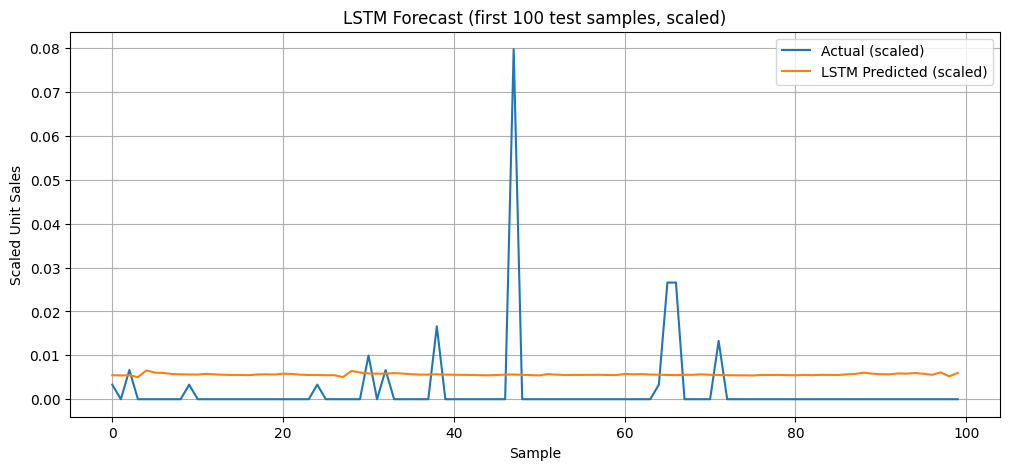

In [38]:
# Plotten im skalierten Raum
plt.figure(figsize=(12, 5))
plt.plot(y_test_lstm[:100], label='Actual (scaled)')
plt.plot(lstm_pred_scaled[:100], label='LSTM Predicted (scaled)')
plt.title('LSTM Forecast (first 100 test samples, scaled)')
plt.xlabel('Sample')
plt.ylabel('Scaled Unit Sales')
plt.legend()
plt.grid(True)
plt.show()

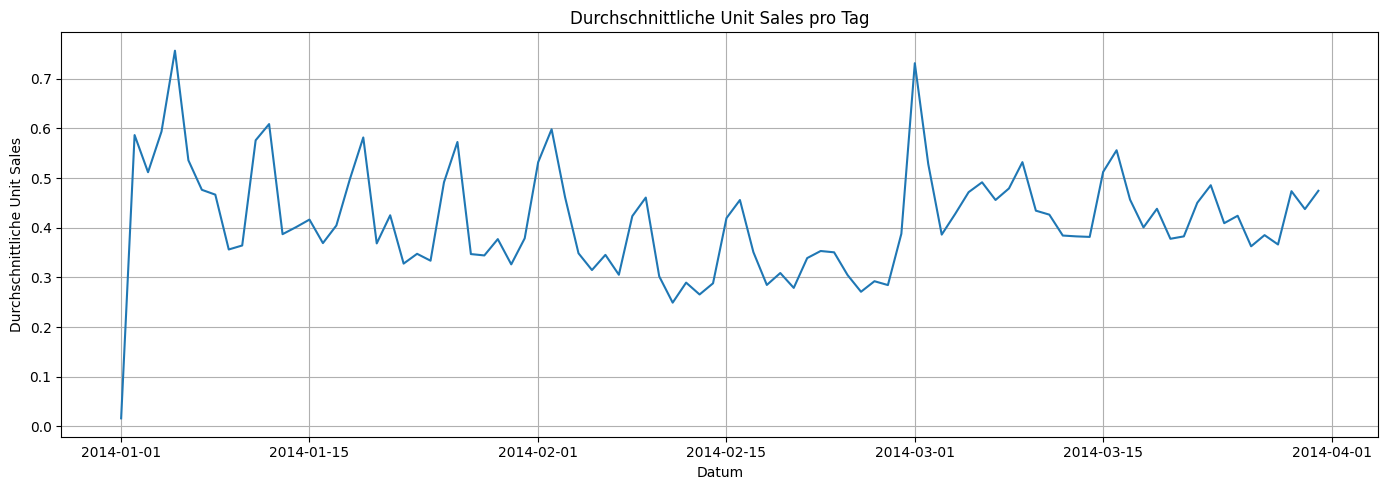

In [39]:
# Übersichtlicher Zeitplot
daily_sales = df.groupby('date')['unit_sales'].mean()
plt.figure(figsize=(14, 5))
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Durchschnittliche Unit Sales pro Tag')
plt.xlabel('Datum')
plt.ylabel('Durchschnittliche Unit Sales')
plt.grid(True)
plt.tight_layout()
plt.show()